# Load libraries and data

In [1]:
# load relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# load the data by reading the raw csv file
# use parse_dates argument to read the date column in datetime format
btc = pd.read_csv("./bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv", parse_dates=['Timestamp'], usecols=['Timestamp', 'Weighted_Price'])

# Data Wrangling

In [3]:
btc.shape

(4857377, 2)

In [4]:
# check data types
btc.dtypes

Timestamp          object
Weighted_Price    float64
dtype: object

In [5]:
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.39
1,1325317980,NaN
2,1325318040,NaN
3,1325318100,NaN
4,1325318160,NaN


## Check and drop null values

In [6]:
# check how many rows have non-null values
btc.notnull().sum()

Timestamp         4857377
Weighted_Price    3613769
dtype: int64

As there are over 1 million rows having null value, I'm going to drop them.

In [7]:
# drop null rows
btc = btc.dropna()

In [8]:
# check if null values are all removed
btc.isnull().values.any()

False

In [9]:
btc.shape

(3613769, 2)

In [10]:
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.390000
478,1325346600,4.390000
547,1325350740,4.526411
548,1325350800,4.580000
1224,1325391360,4.580000


## Reset index

In [11]:
btc.reset_index(drop=True, inplace=True)
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.390000
1,1325346600,4.390000
2,1325350740,4.526411
3,1325350800,4.580000
4,1325391360,4.580000


# Explore the data

## Transform

The timestamps are in Unix time so I'm going to transform it to datetime

In [12]:
btc['Timestamp'] = pd.to_datetime(btc['Timestamp'], unit='s')
btc.dtypes

Timestamp         datetime64[ns]
Weighted_Price           float64
dtype: object

## Downsample to daily data

In [13]:
btc.index = btc['Timestamp']
btc_daily = btc.resample('D').mean()
btc_daily.head()

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159


In [14]:
btc_daily = btc_daily.dropna()

In [15]:
btc_daily.isnull().values.any()

False

## Plot

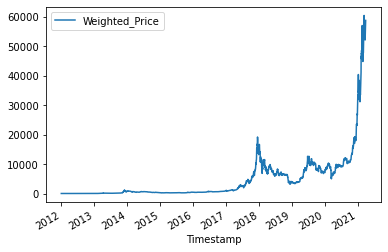

In [16]:
btc_daily.plot()

## Check for stationarity

### 1. Using seasonal_decompse

In [17]:
import statsmodels.api as sm

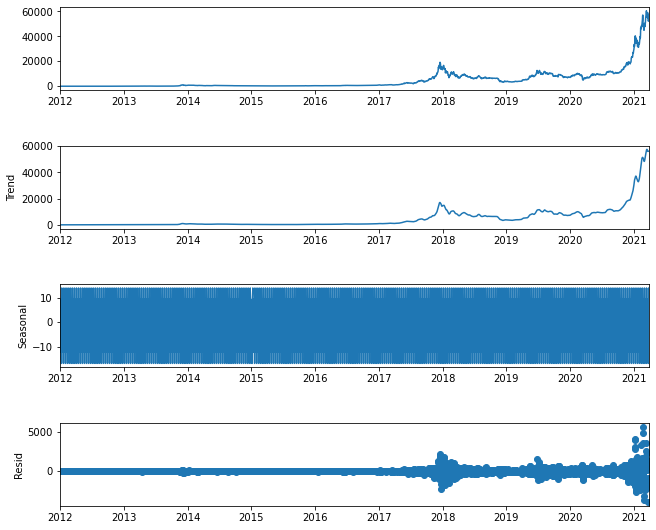

In [18]:
# Seasonal Decomposition
# observed = trend + seasonal + resid
# period(=freq): use to check seasonality

decomposition = sm.tsa.seasonal_decompose(btc_daily, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Does data have:  
- Trend? No fixed trend  
- Seasonality? None 
- Residual? No fixed residual

### 2. Using the ACF and PACF

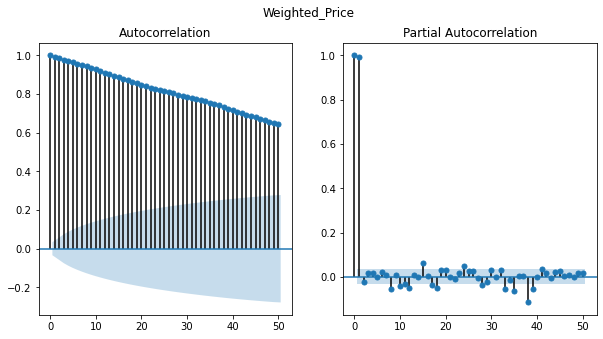

In [19]:
# Plot acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Weighted_Price')
sm.graphics.tsa.plot_acf(btc_daily.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(btc_daily.squeeze(), lags=50, ax=ax[1]);

The ACF tails off slowly (while PACF cuts off after lag 1) so the data is non-stationary.

### 3. Using the augment Dicky-Fuller

In [20]:
from statsmodels.tsa.stattools import adfuller

In [21]:
# Run the ADF test and print the test statistic and the p-value
result = adfuller(btc_daily['Weighted_Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

ADF Statistic: 6.185633110386281
p-value: 1.0
critical values: {'1%': -3.4323058648629248, '5%': -2.862404186780598, '10%': -2.5672300237626606}


Since the ADF statistics is higher than the T-values, 6.18 > -3.43, -2.86, -2.56, null hypothesis cannot be rejected.  
Also, p-value of 1.0 > 0.05 (95% confidence interval), null hypothesis cannot be rejected.  
Hence, the data is non-stationary.

## Taking the difference

In order to make the data stationary, I will take the difference on the data.

##### 1st order differencing

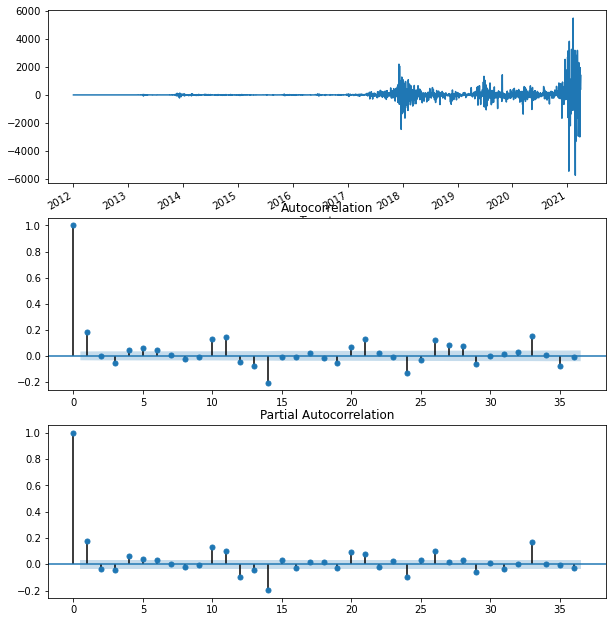

In [22]:
btc_daily_diff_1 = btc_daily.diff(periods=1).dropna()['Weighted_Price']

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12))
btc_daily_diff_1.plot(ax=ax1)
plot_acf(btc_daily_diff_1, ax=ax2)
plot_pacf(btc_daily_diff_1, ax=ax3)
plt.show()

In [23]:
# Run the ADF test and print the test statistic and the p-value
result = adfuller(btc_daily_diff_1)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

ADF Statistic: -9.08653810290712
p-value: 3.926412261826797e-15
critical values: {'1%': -3.4323058648629248, '5%': -2.862404186780598, '10%': -2.5672300237626606}


Since the ADF statistics is lower than the T-values, -9.0865 < -3.43, -2.86, -2.56, null hypothesis can be rejected.  
As well, the p-value of 3.92e-15 < 0.05 (95% confidence interval), null hypothesis can be rejected.

##### 2nd order differencing

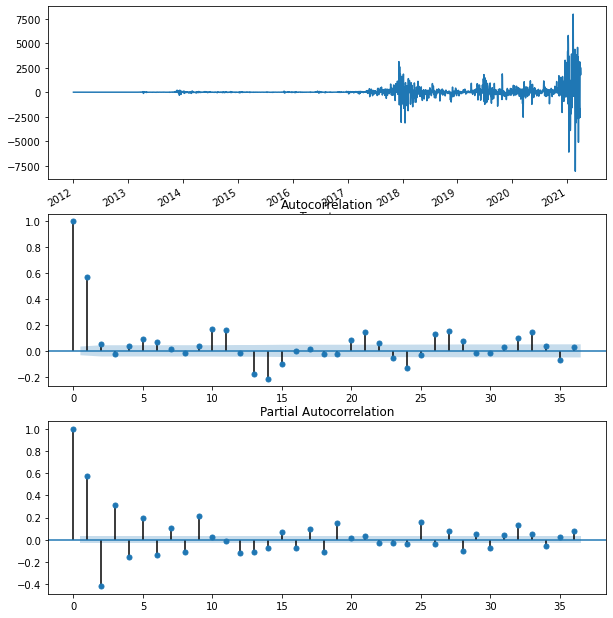

In [24]:
btc_daily_diff_2 = btc_daily.diff(periods=2).dropna()['Weighted_Price']

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12))
btc_daily_diff_2.plot(ax=ax1)
plot_acf(btc_daily_diff_2, ax=ax2)
plot_pacf(btc_daily_diff_2, ax=ax3)
plt.show()

In [25]:
# Run the ADF test and print the test statistic and the p-value
result = adfuller(btc_daily_diff_2)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

ADF Statistic: -9.29166701035828
p-value: 1.175262057693119e-15
critical values: {'1%': -3.43230703553836, '5%': -2.8624047038663196, '10%': -2.5672302990466394}


It seems taking the 1st order differencing would be enough.  

### Split train-test data

Make the test data with the last one month data

In [114]:
# train_test_split
from sklearn.model_selection import train_test_split
#train, test = train_test_split(btc_daily, test_size=(btc_daily.index > '2021-02-28').sum(), shuffle=False, random_state=42)
train, test = train_test_split(btc_daily, test_size=0.3, shuffle=False, random_state=42)


# Modeling - ARIMA

## Fit to the train data

In [115]:
result = adfuller(train)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

ADF Statistic: -1.682086355609681
p-value: 0.44036495378842155
critical values: {'1%': -3.4331536417276274, '5%': -2.8627785955546137, '10%': -2.5674293588855925}


As p-value 0.44 > 0.05, take the differencing

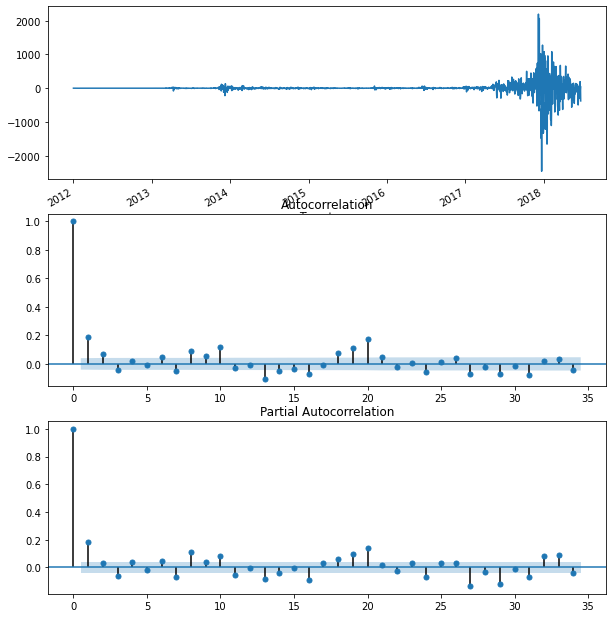

In [116]:
train_diff = train.diff(periods=1).dropna()['Weighted_Price']

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12))
train_diff.plot(ax=ax1)
plot_acf(train_diff, ax=ax2)
plot_pacf(train_diff, ax=ax3)
plt.show()

In [117]:
result = adfuller(train_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

ADF Statistic: -8.779512764228302
p-value: 2.3978090958917432e-14
critical values: {'1%': -3.4331548442701627, '5%': -2.8627791265652154, '10%': -2.56742964160809}


Find the best combination of (p, d, q)

In [118]:
from statsmodels.tsa.arima_model import ARIMA
import itertools

In [129]:
print("Examples of parameter combinations for seasonal ARIMA")
p=range(0,3)
d=range(1,2)
q=range(0,3)
pdq = list(itertools.product(p,d,q)) 

aic = []
for i in pdq:
    model=ARIMA(train_diff.dropna().values, order=(i))
    model_fit = model.fit(trend='c', full_output=True, disp=True)
    print(f"ARIMA : {i} >> AIC : {round(model_fit.aic, 2)}")
    aic.append(round(model_fit.aic, 2))

Examples of parameter combinations for seasonal ARIMA
ARIMA : (0, 1, 0) >> AIC : 32203.05
ARIMA : (0, 1, 1) >> AIC : 31063.98
ARIMA : (0, 1, 2) >> AIC : 30991.62
ARIMA : (1, 1, 0) >> AIC : 31732.57
ARIMA : (1, 1, 1) >> AIC : 30982.68
ARIMA : (1, 1, 2) >> AIC : 30983.14
ARIMA : (2, 1, 0) >> AIC : 31607.99
ARIMA : (2, 1, 1) >> AIC : 30982.12
ARIMA : (2, 1, 2) >> AIC : 30943.96


In [130]:
optimal = [pdq[np.argmin(aic)], min(aic)]
optimal

[(2, 1, 2), 30943.96]

In [131]:
model_diff = ARIMA(train_diff.values, order = optimal[0])
model_diff_fit = model_diff.fit(trend='c', full_output=True, disp=True)
model_diff_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2361
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -15465.979
Method:                       css-mle   S.D. of innovations            169.033
Date:                Sun, 31 Oct 2021   AIC                          30943.958
Time:                        21:49:17   BIC                          30978.559
Sample:                             1   HQIC                         30956.556
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.007      0.529      0.597      -0.009       0.016
ar.L1.D.y     -0.7133      0.033    -21.716      0.000      -0.778      -0.649
ar.L2.D.y      0.2249      0.020     11.124      0.000       0.185       0.265
ma.L1.D.y     -0.0951      0.028     -3.403      0.001      -0.150      -0.040
ma.L2.D.y     -0.9049      0.028    -32.387      0.000      -0.960      -0.850
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0526           +0.0000j            1.0526            0.5000
AR.2            4.2239           +0.0000j            4.2239            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.1051           +0.0000j            1.1051            0.5000
-----------------------------------------------------------------------------
"""

## Predict

In [132]:
fc = model_diff_fit.forecast(steps=1)
print(fc)

(array([-55.49952517]), array([169.03312199]), array([[-386.79835647,  275.79930613]]))


In [133]:
start = test.index[0]
print(start)

2018-06-23 00:00:00


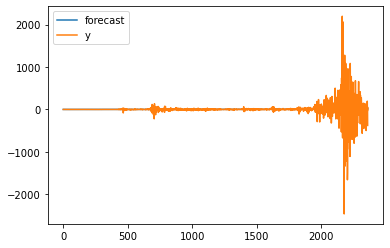

In [134]:
model_diff_fit.plot_predict()
plt.show()

In [135]:
# use model to forecast
pred = model_diff_fit.forecast(steps=test.shape[0])
pred_val = pred[0]
pred_lw = pred[2][:,0]
pred_up = pred[2][:,1]
pred_idx = list(test.index)

print(pred_val)

[-55.49952517 -34.99144976  22.7895646  ...  10.41056023  10.4140132
  10.41746616]


In [136]:
from sklearn.metrics import r2_score
r2 = r2_score(test['Weighted_Price'], pred_val)
r2

-1.0730314639640883

Text(0.5, 0.98, 'ARIMA (2, 1, 2) Prediction Results (r2 score : -1.07)')

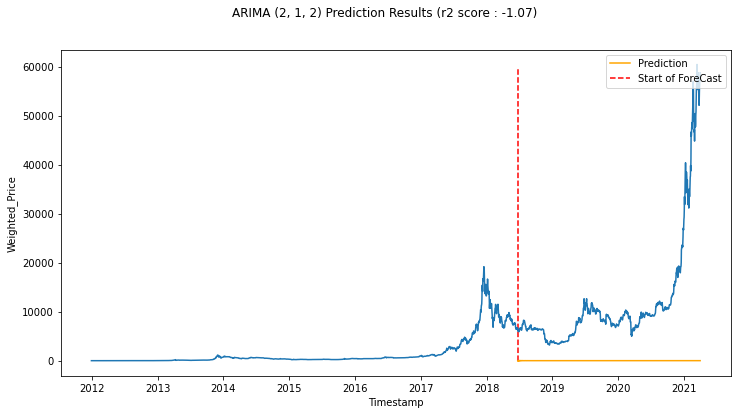

In [137]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=btc_daily, x=btc_daily.index, y='Weighted_Price', ax=ax)
ax.vlines(start, 0, 60000, linestyle='--', color='r', label='Start of ForeCast')
ax.plot(pred_idx, pred_val, color='orange', label='Prediction')
plt.legend(loc='upper right')
plt.suptitle(f"ARIMA {optimal[0]} Prediction Results (r2 score : {round(r2,2)})")

Narrow down the date range to see more specifically

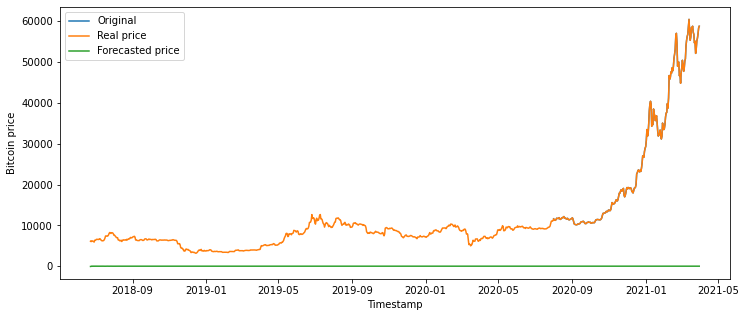

In [138]:
fc = pd.DataFrame(pred[0], index=test.index, columns=test.columns)

plt.figure(figsize=(12,5))
plt.plot(btc_daily.loc[datetime(2020,8,1):,:], label="Original")
plt.plot(test, label="Real price")
plt.plot(fc, label="Forecasted price")
plt.xlabel("Timestamp")
plt.ylabel("Bitcoin price")
plt.legend()
plt.show()

# Modeling - SARIMA

## Fit

In [72]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [75]:
# SARIMA
# parameter search
print("Examples of parameter combinataions for Seasonal ARIMA")
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

aic = []
params = []

for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train.dropna().values, order = (i), seasoanl_order = (j))
            model_fit = model.fit()
            print(f"SARIMA : {i}{j} >> AIC {round(model_fit.aic,2)}")
            aic.append(round(model_fit.aic,2))
            params.append((i,j))
        except:
            pass

Examples of parameter combinataions for Seasonal ARIMA
SARIMA : (0, 1, 0)(0, 1, 0, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(0, 1, 1, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(0, 1, 2, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(1, 1, 0, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(1, 1, 1, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(1, 1, 2, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(2, 1, 0, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(2, 1, 1, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(2, 1, 2, 12) >> AIC 48397.47
SARIMA : (0, 1, 1)(0, 1, 0, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(0, 1, 1, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(0, 1, 2, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(1, 1, 0, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(1, 1, 1, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(1, 1, 2, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(2, 1, 0, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(2, 1, 1, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(2, 1, 2, 12) >> AIC 48275.66
SARIMA : (0, 1, 2)(0, 1, 0, 12) >> AIC 48277.66
SARIMA : (0, 1, 2)(0, 1, 1, 12) >

In [85]:
optimal = [params[np.argmin(aic)], min(aic)]
optimal

[((0, 1, 0), (0, 1, 1, 12)), 48273.89]

In [86]:
SARIMA_model_opt = SARIMAX(train_diff.values, order=optimal[0][0], seasonal_order = optimal[0][1])
SARIMA_model_opt_fit = SARIMA_model_opt.fit()
SARIMA_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 3344
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood              -24938.174
Date:                              Sun, 31 Oct 2021   AIC                          49880.349
Time:                                      21:25:38   BIC                          49892.571
Sample:                                           0   HQIC                         49884.722
                                             - 3344                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9997      0.059    -16.808      0.000      -1.116      -0.883
sigma2      1.822e+05   1.04e+04     17.448      0.000    1.62e+05    2.03e+05
===================================================================================
Ljung-Box (Q):                     1162.77   Jarque-Bera (JB):            774116.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             950.60   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        77.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
# use model to forecast
pred = SARIMA_model_opt_fit.get_forecast(steps=test.shape[0])
pred_val = pred.predicted_mean
pred_lw = pred.conf_int()[:,0]
pred_up = pred.conf_int()[:,1]
pred_idx = list(test.index)

r2 = r2_score(test, pred_val)
r2

-236.24044055172587

get_prediction vs get_forecast??

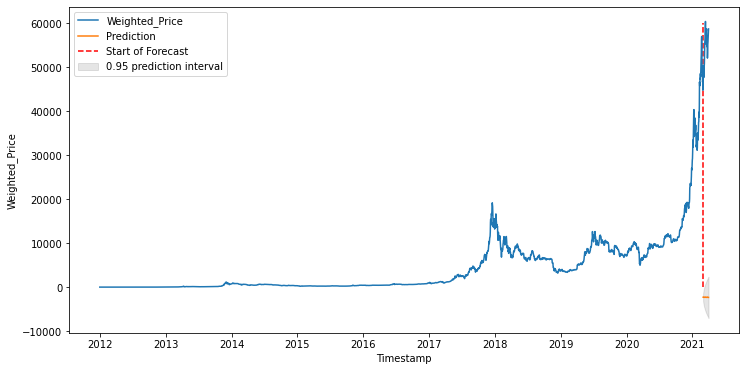

In [90]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=btc_daily, x=btc_daily.index, y='Weighted_Price', label='Weighted_Price')
ax.vlines(start, 0, 60000, linestyle='--', color='r', label='Start of Forecast')
ax.plot(pred_idx, pred_val, label='Prediction')
ax.fill_between(pred_idx, pred_lw, pred_up, color='k', alpha=0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.show()

# Modeling - Facebook Prophet

In [96]:
!pip3 install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-install-s29wacq8/fbprophet/setup.py'"'"'; __file__='"'"'/private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-install-s29wacq8/fbprophet/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-wheel-plrn_eas
       cwd: /private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-install-s29wacq8/fbprophet/
  Complete output (38 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib
  creating build/lib/fbprophet
  creating build/lib/fbprophet/stan_model
  Traceback (most recent call last):


Failed to build fbprophet
    Running setup.py install for fbprophet ... error
    ERROR: Command errored out with exit status 1:
     command: /opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-install-s29wacq8/fbprophet/setup.py'"'"'; __file__='"'"'/private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-install-s29wacq8/fbprophet/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-record-m9e5mxpd/install-record.txt --single-version-externally-managed --compile --install-headers /opt/anaconda3/include/python3.8/fbprophet
         cwd: /private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-install-s29wacq8/fbprophet/
    Complete output (40 lines):
    running install
    running bui

In [97]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'